In [11]:
import datetime
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse
import time
from lib.helper import Stopwatch
from lib.network_x_helper import island_to_network_x
from lib.powerflow import fast_newton_raphson_sparse, solve_powerflow_newton_raphson, generate_admittance_matrix,  get_cable_currents_from_impedance, get_cable_currents, get_power_sparse, generate_admittance_matrix_sparse, fast_newton_raphson
from lib.topology_helper import get_random_switch_state_recursive
from lib.vep_api_client import VEP_CRUD_Client, load_conducting_topology, load_grids_in_geo_bounds, load_load_profiles, load_voltge_groups
from lib.vep_grid_model_helper import get_cable_impedances, get_spec_fks, get_inter_island_connections_by_island, get_inter_island_edges_by_island, get_islands_from_topology, get_pf_grid, get_pf_node_loads, get_prosumers, load_models_as_nparray, merge_island_leafs, switchstate_to_super_islands,get_cable_nominal_current
from lib.network_x_helper import inter_island_to_network_x, get_island_affiliation_node_coloring
from lib.topology_helper import get_random_templates
from lib.topology_helper import select_random_branch_island_first
import matplotlib
import os
import math
from lib.network_x_helper import pf_island_to_network_x
import geopy
import pandas as pd

In [ ]:
base_url = 'http://localhost:5000'

# city center
# geo_bounds = (47.408126729960294, 8.54009197830886, 47.41605511342204, 8.54807423243775) 
# folder_name = 'urban1'
# colormap = 'tab20'
# fully_contained = False
# geo_bounds = (47.4087, 8.5100, 47.42044, 8.52066)

# suburb
# geo_bounds = (47.39145482630907, 8.536954701895919, 47.39354526150449, 8.541211021572634) 
# folder_name = 'swiss_suburb'
# colormap = 'Dark2'
# fully_contained = False

# urban
geo_bounds = (47.372935674583466, 8.486676422390591, 47.377964159835436, 8.49614563996271)
folder_name = 'urban2'
colormap = 'tab20'
fully_contained = False

#city center2
# geo_bounds = (47.37397965320707, 8.524932763912348, 47.375584191947645, 8.52824380990137)
# folder_name = 'city_center2'
# colormap = 'tab20'
# fully_contained = False

# village
# geo_bounds = (47.34000627253463, 8.529865983704495, 47.35215746182357, 8.542636364033399)
# folder_name = 'village'
# colormap = 'tab20'
# fully_contained = True

#suburb 2
# geo_bounds = (47.40142317623826, 8.492982561894841, 47.40416861853659, 8.503307598663959)
# folder_name = 'suburb2'
# colormap = 'tab20'
# fully_contained = False

hour_day = 40

out_dir = f'./out/switchstate_exploring/{folder_name}'
os.makedirs(out_dir, exist_ok=True)

## Load everything from the server

In [13]:
client = VEP_CRUD_Client(base_url)

voltage_groups = load_voltge_groups(client)
print('Loaded voltage groups')

voltage_group = next((g for g in voltage_groups if g['VoltageGroup']['UpperLimit'] <= 1000))

grids_in_geo_bounds = load_grids_in_geo_bounds(client, voltage_group, geo_bounds, False)
print(f'Loaded {len(grids_in_geo_bounds)} grid fks')

topology = list()
i = 0
while i < len(grids_in_geo_bounds):
    print(f'Loading grids {i} to {i+2}')
    topology.extend(load_conducting_topology(client, grids_in_geo_bounds[i:min(i+2, len(grids_in_geo_bounds))]))
    i+=2

print('Loaded grids')

spec_fks = get_spec_fks(topology)

specs = client.get_many(list(spec_fks.values()))
spec_by_uuid = dict[str, dict]()
for spec in specs:
    spec_by_uuid[spec['UUID']] = spec

print('Loaded specs')

cable_impedances = get_cable_impedances(topology, spec_by_uuid)
cable_nominal = get_cable_nominal_current(topology, spec_by_uuid)
prosumer_fks = get_prosumers(topology)

start = datetime.datetime(2025, 1, 1)
end = start + datetime.timedelta(days=1)
load_models = list()
i = 0
while i < len(prosumer_fks):
    print(f'Loading models {i} to {i+100}')
    load_models.extend(load_load_profiles(client, prosumer_fks[i:min(i+100, len(prosumer_fks))], start, end))
    i += 100
load_timeseries_by_uuid, load_timeseries_len = load_models_as_nparray(load_models)

total_node_count = sum([len(t['nodes']) for t in topology])
total_edge_count = sum([len(t['edges']) for t in topology])

print(f'Grid count:             {len(topology)}')
print(f'Total node count:       {total_node_count}')
print(f'Total edge count:       {total_edge_count}')
print(f'Total cable count:      {len(cable_impedances)}')
print(f'Total prosumer count:   {len(prosumer_fks)}')

Loaded voltage groups
Loaded 7 grid fks
Loading grids 0 to 2
Loading grids 2 to 4
Loading grids 4 to 6
Loading grids 6 to 8
Loaded grids
Loaded specs
Loading models 0 to 100
Loading models 100 to 200
Loading models 200 to 300
Grid count:             7
Total node count:       1463
Total edge count:       1515
Total cable count:      938
Total prosumer count:   253


## Determine islands

In [14]:
trafo_max_powers = dict[str, float]()

# remove dual transformers
for grid in topology:
    if len(grid['transformers']) < 1:
        continue

    total_rated_power = 0

    for trafo in grid['transformers']:
        for s in trafo['specs']:
            spec = spec_by_uuid[s['uuid']]
            total_rated_power += spec['RatedPower']

    trafo = grid['transformers'][0]
    grid['transformers'] = [trafo]
    trafo_max_powers[trafo['primaryKey']['uuid']] = total_rated_power
    
islands, comp_to_island, inter_island_edges, island_trafos, component_by_uuid = get_islands_from_topology(topology) 

total_merge_count = merge_island_leafs(islands, comp_to_island, inter_island_edges, island_trafos)
print(f'Merged {total_merge_count} leaf islands')

inter_island_edges_by_island = get_inter_island_edges_by_island(comp_to_island, inter_island_edges)
inter_island_connections_by_island = get_inter_island_connections_by_island(inter_island_edges, comp_to_island)

g = inter_island_to_network_x(inter_island_connections_by_island, islands.keys())
unconnected_islands = list(nx.connected_components(g))
print(f'Found {len(unconnected_islands)} unconnected structures, only keeping largest')

biggeset_island = max(unconnected_islands, key=lambda islnd: len(islnd))

for islnd in list(islands.keys()):
    if islnd in biggeset_island:
        continue
    
    for c in islands[islnd]:
        del comp_to_island[c]
        
    del islands[islnd]
    if islnd in inter_island_connections_by_island:
        del inter_island_connections_by_island[islnd]
    if islnd in island_trafos:
        del island_trafos[islnd]

new_islands = dict()
new_ids = dict[int, int]()
j = 0
for i, values in islands.items():
    new_ids[i] = j
    new_islands[j] = values
    j+=1

for c, old_id in comp_to_island.items():
    comp_to_island[c] = new_ids[old_id]

new_island_trafos = dict()
for old_id, values in island_trafos.items():
    new_island_trafos[new_ids[old_id]] = values

islands = new_islands
island_trafos = new_island_trafos

inter_island_edges_by_island = get_inter_island_edges_by_island(comp_to_island, inter_island_edges)
inter_island_connections_by_island = get_inter_island_connections_by_island(inter_island_edges, comp_to_island)

print(f'Grids: {len(topology)}')
print(f'Trafos: {len(island_trafos)}') 
print(f'Islands: {len(islands)}')

total_inter_island = sum(len(x) for x in inter_island_connections_by_island.values())/2

print(f'Inter island swtiches: {total_inter_island}')

standard_sw_g = nx.Graph()
for e in inter_island_edges:
    if e['currentSwitchState']:
        continue
    uuid_a = e['nodeA']['uuid']
    uuid_b = e['nodeB']['uuid']

    if uuid_a not in comp_to_island or uuid_b not in comp_to_island:
        continue

    a = comp_to_island[uuid_a]
    b = comp_to_island[uuid_b]
    
    if a == b or a not in islands or b not in islands:
        continue

    standard_sw_g.add_edge(a, b)

for islnd in islands.keys():
    standard_sw_g.add_node(islnd)

sws = list(nx.connected_components(standard_sw_g))
trafos_per_island = [len([y for y in x if y in island_trafos]) for x in sws]

print(f'Islands in sss: {len(sws)}')
print(f'Max trafos per island in standard sss: {max(trafos_per_island)}')
unconnected_sws = len([x for x in trafos_per_island if x == 0])
print(f'Unconnected islands in sss: {unconnected_sws}')

g = inter_island_to_network_x(inter_island_connections_by_island, islands.keys())
layout = nx.kamada_kawai_layout(g)


Merged 426 leaf islands
Found 14 unconnected structures, only keeping largest
Grids: 7
Trafos: 7
Islands: 101
Inter island swtiches: 150.0
Islands in sss: 7
Max trafos per island in standard sss: 1
Unconnected islands in sss: 0


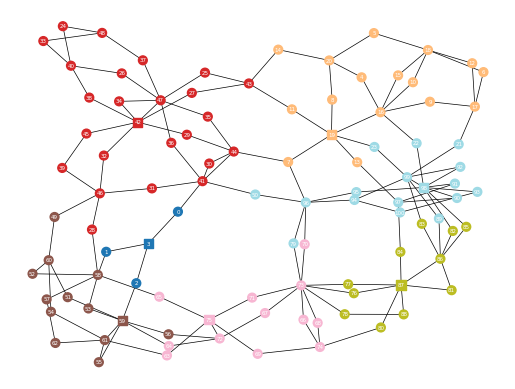

In [15]:
trafos = [x for x in list(g) if x in island_trafos]
non_trafos = [x for x in list(g) if x not in island_trafos]
node_colors = [(1 if x in island_trafos else 0) for x in list(g)]
nx.draw_networkx_nodes(g, pos=layout, node_size=10, node_shape='o', nodelist=non_trafos, node_color=np.full(len(non_trafos), 1), cmap=colormap, margins=0)
nx.draw_networkx_nodes(g, pos=layout, node_size=15, node_shape='s', nodelist=trafos, node_color='#000000', margins=0)
nx.draw_networkx_edges(g, pos=layout, width=.5)

# plt.title('Atomic island topology')
plt.box(False)
plt.savefig(f'./out/switchstate_exploring/{folder_name}/topology.png', dpi=400, bbox_inches="tight")
plt.clf()


def draw_atomic_islands_fancy(g, layout, node_colors, island_trafos, ax = None, size=40, labels=True, no_box=True):
    non_trafos = [x for x in list(g) if x not in island_trafos]
    node_color_non_trafo = list()
    node_color_trafo = list()

    i = 0
    for x in list(g):
        if x not in island_trafos:
            node_color_non_trafo.append(node_colors[i])
        else:
            node_color_trafo.append(node_colors[i])
        i += 1

    nx.draw_networkx_nodes(g, layout, ax=ax, node_size=size, node_shape='o', nodelist=non_trafos, node_color=node_color_non_trafo, cmap=colormap, vmax=max(node_colors), vmin=min(node_colors), margins=0)
    nx.draw_networkx_nodes(g, layout, ax=ax, node_size=size*(1 + 1/8), node_shape='s', nodelist=trafos, node_color=node_color_trafo, cmap=colormap, vmax=max(node_colors), vmin=min(node_colors), margins=0)
    nx.draw_networkx_edges(g, layout, ax=ax, width=.5)
    if labels:
        nx.draw_networkx_labels(g, layout, ax=ax, font_size=4, font_color='#ffffff')

    if no_box:
        plt.box(False)

node_colors = np.array(get_island_affiliation_node_coloring(islands, sws, g))
draw_atomic_islands_fancy(g, layout, node_colors, island_trafos)
plt.savefig(f'./out/switchstate_exploring/{folder_name}/topology_sss.png', dpi=600, bbox_inches="tight")


merged unconnected islands in 0 steps


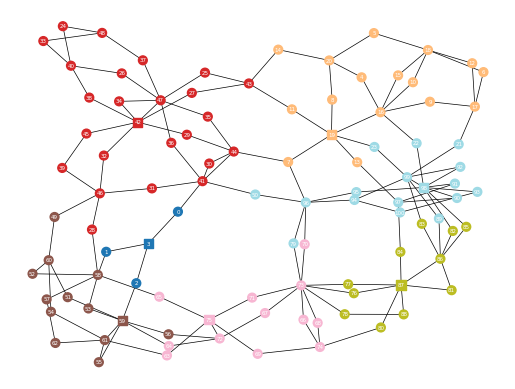

In [16]:
sws_patched = [set(s) for s in sws]
sws_total_power = list(np.zeros(len(sws)))

i = 0
for super_island in sws:
    power = 0
    for island in super_island:
        for c in islands[island]:
            if c in load_timeseries_by_uuid:
                power += load_timeseries_by_uuid[c][hour_day]
            
    sws_total_power[i] = power

    i += 1

i = 0 
while True:

    unconnected_found = False

    for j in range(0, len(sws_patched)):

        islnd = sws_patched[j]

        # has trafo case
        if len(islnd.intersection(island_trafos.keys())) > 0:
            continue

        unconnected_found = True
        adjecent_islands = set()
        for opt in islnd:
            adjecent_islands.update(inter_island_connections_by_island[opt])
        adjecent_islands.difference_update(sws_patched[j])
        
        merge_options = [x for x in range(0, len(sws_patched)) if len(sws_patched[x].intersection(adjecent_islands)) > 0]
        merge_candate = min(merge_options, key=lambda i: sws_total_power[i])
        sws_patched[merge_candate].update(islnd)
        sws_total_power[merge_candate] += sws_total_power[j]
        break

    if not unconnected_found:
        break

    sws_patched.pop(j)
    sws_total_power.pop(j)
    
    i += 1

print(f'merged unconnected islands in {i} steps')
node_colors = get_island_affiliation_node_coloring(islands, sws_patched, g)
draw_atomic_islands_fancy(g, layout, node_colors, island_trafos)
plt.savefig(f'./out/switchstate_exploring/{folder_name}/topology_sss_patched.png', dpi=600, bbox_inches="tight")

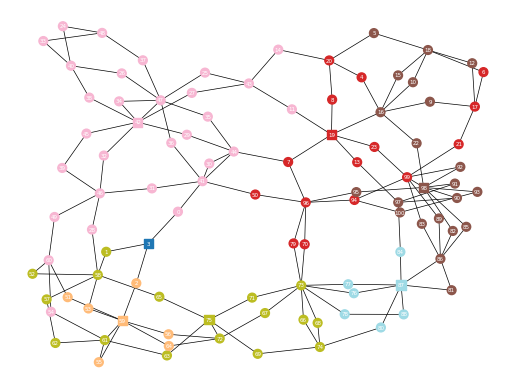

In [17]:
sample_count = 10

size_samples1 = np.zeros((sample_count, len(trafos)), dtype=int)
size_samples2 = np.zeros((sample_count, len(trafos)), dtype=int)

for i in range(0, sample_count):
    sst1 = get_random_templates(inter_island_connections_by_island, len(islands), trafos, select_random_branch_island_first)
    sst2 = get_random_templates(inter_island_connections_by_island, len(islands), trafos)

    size_samples1[i, :] = [len(t) for t in sst1]
    size_samples2[i, :] = [len(t) for t in sst2]

max_overall = max(np.max(size_samples1), np.max(size_samples2))
cmap = matplotlib.colormaps[colormap]
trafo_colors = [node_colors[t] for t in trafos]
colors = list(cmap(np.array(trafo_colors)/(max(node_colors))))

sns.boxplot(size_samples1, palette=colors)
plt.ylim(0, max_overall*1.1)
plt.ylabel('Template size')
plt.xlabel('Transformer')
plt.savefig(f'./out/switchstate_exploring/{folder_name}/random_switchstate_distribution_tempalte_p.png', dpi=400, bbox_inches="tight")
plt.clf()

sns.boxplot(size_samples2, palette=colors)
plt.ylim(0, max_overall*1.1)
plt.ylabel('Template size')
plt.xlabel('Transformer')
plt.savefig(f'./out/switchstate_exploring/{folder_name}/random_switchstate_distribution_choice_p.png', dpi=400, bbox_inches="tight")

plt.clf()
random_template = get_random_templates(inter_island_connections_by_island, len(islands), trafos)
node_colors = get_island_affiliation_node_coloring(islands, random_template, g)
draw_atomic_islands_fancy(g, layout, node_colors, island_trafos)
plt.show()


3


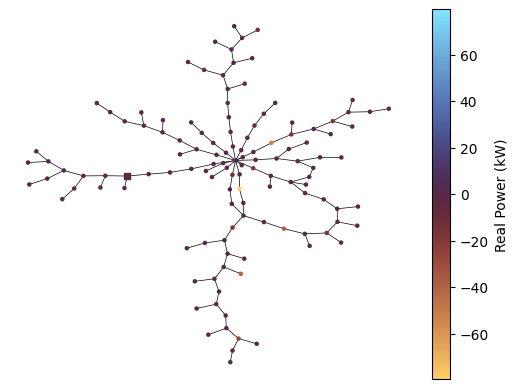

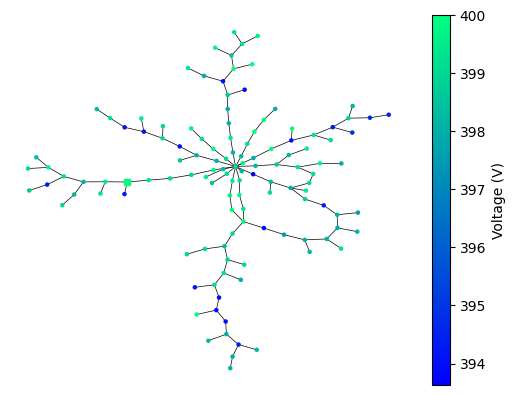

In [18]:
def to_human_compare_df(df):

    compare_df = pd.DataFrame()
    compare_df['Score (x100)'] = df['score']*100
    compare_df['Min. Voltage (V)'] = df['min_voltage']
    compare_df['Max. cable utilization (%)'] = df['max_cable_util']*100
    compare_df['Avg. cable utilization (%)'] = df['avg_cable_util']*100
    compare_df['Max. transformer utilization (%)'] = df['max_trafo_util']*100
    compare_df['Avg. transformer utilization (%)'] = df['avg_trafo_util']*100
    compare_df['Toal line losses (kW)'] = (np.real(df['total_line_loss']) + np.imag(df['total_line_loss']))/1000
    return compare_df

def plot_powers(g, layout, powers: list[complex], mode: str = 'real'):

    # cmp = 'RdYlBu'
    cmp = 'managua'

    if mode == 'real':
        powers_mag = np.real(powers) / 1000

    if mode == 'react':
        powers_mag = np.imag(powers) / 1000

    ax = plt.gca()
    ax.inset_axes([0.95, 0.1, 0.05, 0.8])
    ax.cla()

    max_power = np.max(np.abs(powers_mag))
    min_power = -max_power

    draw_fancy(g, layout, cmp, powers_mag, ax, max_power, min_power)

    sm = plt.cm.ScalarMappable(cmap=cmp, norm=plt.Normalize(vmin=min_power, vmax=max_power))
    clbr = plt.colorbar(sm, ax=ax)

    clbr.ax.set_ylabel('Real Power (kW)' if mode == 'real' else 'Reactive Power (kW)')

def plot_votlage(g, layout, voltages: list[complex]):

    cmp = 'winter'

    voltage_mag = np.abs(voltages)

    ax = plt.gca()
    ax.inset_axes([0.95, 0.1, 0.05, 0.8])
    ax.cla()

    draw_fancy(g, layout, cmp, voltage_mag, ax, np.max(voltage_mag), np.min(voltage_mag))

    sm = plt.cm.ScalarMappable(cmap=cmp, norm=plt.Normalize(vmin =np.min(voltage_mag), vmax=np.max(voltage_mag)))
    sm._A = []
    clbr = plt.colorbar(sm, ax=ax)
    clbr.ax.set_ylabel('Voltage (V)')

def plot_cable_currents(g, layout, currents: list[float]):

    # cmp = mpl.colormaps['Wistia']
    cmp = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green", "yellow", "red"])

    ax = plt.gca()
    ax.inset_axes([0.95, 0.1, 0.05, 0.8])
    ax.cla()

    min_c = np.min(currents)
    max_c = np.max(currents)

    nx.draw_networkx_nodes(g, layout, ax=ax, node_size=2, node_shape='o', nodelist=list(g)[1:], node_color='black', margins=0)
    nx.draw_networkx_nodes(g, layout, ax=ax, node_size=20, node_shape='s', nodelist=list(g)[0:1], node_color='black', margins=0)
    nx.draw_networkx_edges(g, layout, width=2,  edge_color=currents, edge_cmap=cmp, edge_vmin=min_c, edge_vmax=max_c)    

    sm = plt.cm.ScalarMappable(cmap=cmp, norm=plt.Normalize(vmin=min_c, vmax=max_c))
    sm._A = []
    clbr = plt.colorbar(sm, ax=ax)
    clbr.ax.set_ylabel('Current (A)')

def draw_fancy(g, layout, cmp, powers_mag, ax, max_power, min_power):
    draw_nodes_fancy(g, layout, cmp, powers_mag, ax, max_power, min_power)
    nx.draw_networkx_edges(g, layout, ax=ax, width=.5)

def draw_nodes_fancy(g, layout, cmp, powers_mag, ax, max_power, min_power):
    nx.draw_networkx_nodes(g, layout, ax=ax, node_size=5, node_shape='o', nodelist=list(g)[1:], node_color=powers_mag[1:], cmap=cmp, vmax=max_power, vmin=min_power, margins=0)
    nx.draw_networkx_nodes(g, layout, ax=ax, node_size=20, node_shape='s', nodelist=list(g)[0:1], node_color=powers_mag[0:1], cmap=cmp, vmax=max_power, vmin=min_power, margins=0)


super_islands = switchstate_to_super_islands(islands, island_trafos, inter_island_edges_by_island, [list(s) for s in sws_patched])
island = [x for x in super_islands][3]
pf_nodes, pf_edges = get_pf_grid(cable_impedances, component_by_uuid, island)
power = get_pf_node_loads(load_timeseries_by_uuid, load_timeseries_len, pf_nodes)
p = -power[:, 36] # skip slack

admittance = generate_admittance_matrix(len(pf_nodes), pf_edges)
voltages, iterations, convergance = fast_newton_raphson(admittance, p[1:], complex(400, 0), acceptance_delta=1e-4, max_iterations=15)

print(iterations)

cable_currents = get_cable_currents_from_impedance(voltages, pf_edges)

pf_g = pf_island_to_network_x(pf_edges)
layout = nx.kamada_kawai_layout(pf_g)

plot_powers(pf_g, layout, p)
plt.box(False)
plt.savefig(f'{out_dir}/pf_island_powers.png', dpi=600, bbox_inches='tight')
plt.show()

plot_votlage(pf_g, layout, voltages)
plt.box(False)
plt.savefig(f'{out_dir}/pf_island_voltage.png', dpi=600, bbox_inches='tight')
plt.show()

# plot_cable_currents(pf_g, layout, np.abs(np.real(cable_currents)))
# plt.box(False)
# plt.savefig(f'{out_dir}/pf_island_currents.png', dpi=600, bbox_inches='tight')
# plt.show()

## Run experiment

Potential measures:
- power stats (avg, std, etc)
- voltage stats
- island size
- atomic island count
- line loading stats
- trafo loading stats
- net power (without trafo?)
- geo extend stats
- deveation from standard switchstate
- networkx measures
- Losses


In [19]:
import geopy.distance

max_voltage_delta = 0.15

def get_geo_extend(pf_nodes: list[set[str]]):
    min_lat = 90
    min_lon = 90
    max_lat = 0
    max_lon = 0
    for pf_node in pf_nodes:
        for n in pf_node:
            if n not in component_by_uuid:
                continue
            comp = component_by_uuid[n]
            if 'lat' not in comp:
                continue
            if comp['lat'] < min_lat:
                min_lat = comp['lat']
            if comp['lon'] < min_lon:
                min_lon = comp['lon']
            if comp['lat'] > max_lat:
                max_lat = comp['lat']
            if comp['lon'] > max_lon:
                max_lon = comp['lon']

    return geopy.distance.distance((min_lat, min_lon), (max_lat, max_lon)).m

def run_pf_iteration(p_balance, sw, super_islands, hour, calc_graph_measures=False):
    pf_edge_count = 0
    min_voltage = 1e99
    max_voltage = 0
    max_util= 0
    total_util= 0
    max_trafo_util = 0
    total_trafo_util = 0
    total_line_loss = 0
    total_power = 0
    total_shortest_path = 0
    total_geo_extend = 0
    total_density = 0
    # sw.lap_section('build_island_t')

    j = 0
    for island in super_islands:
        pf_nodes, pf_edges = get_pf_grid(cable_impedances, component_by_uuid, island)

        # sw.lap_section('pf_grid_setup_t')

        if len(pf_nodes) < 2:
            continue

        admittance, admittance_magnitutes_sparse, admittance_angles_sparse = generate_admittance_matrix_sparse(len(pf_nodes), pf_edges, format='all')

        # sw.lap_section('admittance_t')

        power = get_pf_node_loads(load_timeseries_by_uuid, load_timeseries_len, pf_nodes)
        p = -power[1:, hour] # skip slack

        # sw.lap_section('power_t')

        voltages, iterations, convergance = fast_newton_raphson_sparse(admittance_magnitutes_sparse, admittance_angles_sparse, p, complex(400, 0), acceptance_delta=1e-3, max_iterations=15)

        if not convergance:
            return {
                'converged': False,
                'failing_templae': j,
                'pf_iterations': iterations
            }
        
        nx_g = pf_island_to_network_x(pf_edges)

        if calc_graph_measures:
            total_shortest_path += np.average([x for x in nx.single_source_shortest_path_length(nx_g, 0).values()])

            total_density += nx.density(nx_g)
            total_geo_extend += get_geo_extend(pf_nodes)

        power = get_power_sparse(admittance, voltages)
        slack_power = power[0]

        total_power += np.sum([complex(abs(x.real), abs(x.imag)) for x in p])

        trafo = next(x for x in pf_nodes[0] if x in trafo_max_powers)
        trafo_rated_power = trafo_max_powers[trafo]
        trafo_power = abs(slack_power)
        trafo_util = trafo_power/trafo_rated_power

        total_trafo_util += trafo_util

        if trafo_util > max_trafo_util:
            max_trafo_util = trafo_util

        p_balance[j] = np.sum(np.real(p)) #overall power of prosumers

        currents = get_cable_currents_from_impedance(voltages, pf_edges)
        inverse_currents = get_cable_currents_from_impedance(voltages, [(e[1], e[0], e[2], e[3]) for e in pf_edges])

        rated = [cable_nominal[x[3]] for x in pf_edges]
        currents_mag = np.abs(currents)
        cable_util = currents_mag/rated

        max_u = np.max(cable_util)
        if max_u > max_util:
            max_util = max_u

        total_util += np.sum(cable_util)
        pf_edge_count += len(pf_edges)

        max_v = np.real(voltages).max()
        min_v = np.real(voltages).min()
        if min_v < min_voltage:
            min_voltage = min_v
        if max_v > max_voltage:
            max_voltage = max_v

        i = 0
        for c in pf_edges:
            current = currents[i]
            inverse_current = inverse_currents[i]
            a = c[0]
            b = c[1]
            total_line_loss += -((voltages[a] * current.conjugate()) + (voltages[b] * inverse_current.conjugate()))
            i+=1

        # sw.lap_section('res_t')
        j+=1

    res = {
        'converged': True,
        'pf_edge_count': pf_edge_count,
        'min_voltage': min_voltage,
        'max_voltage': max_voltage,
        'max_cable_util': max_util,
        'avg_cable_util': total_util/pf_edge_count,
        'max_trafo_util': max_trafo_util,
        'avg_trafo_util': total_trafo_util/len(trafos),
        'total_line_loss': total_line_loss,
        'total_power': total_power,
        'normalized_line_loss': total_line_loss/total_power
    }

    if calc_graph_measures:
        res['avg_steps_trafo'] =  total_shortest_path/len(trafos)
        res['avg_density'] = total_density/len(trafos)
        res['avg_geo_extend'] = total_geo_extend/len(trafos)
    
    return res

def score_configuration(pf_result):

    min_voltage = pf_result['min_voltage']
    max_voltage = pf_result['max_voltage']
    max_util = pf_result['max_cable_util']
    avg_util = pf_result['avg_cable_util']
    max_trafo_util = pf_result['max_trafo_util']
    avg_trafo_util = pf_result['avg_trafo_util']
    normalized_line_losses = pf_result['normalized_line_loss']

    min_voltage_score = min(max(400*(1 + max_voltage_delta) - max_voltage, 0)/(400*max_voltage_delta), 1)
    max_voltage_score = min(max(min_voltage - 400*(1 - max_voltage_delta), 0)/(400*max_voltage_delta), 1)

    max_util_score = max((2.5 - max_util)/2.5, 0)
    avg_util_score = max((1 - avg_util)/1, 0)

    max_trafo_score = max((1.5 - max_trafo_util)/1.5, 0)
    avg_trafo_score = max(1 - avg_trafo_util, 0)

    loss_score = 1-min(abs(normalized_line_losses)*40, 1)

    # print(f'V score: {(min_voltage_score + max_voltage_score)/2}')
    # print(f'U score: {(max_util_score + avg_util_score)/2}')
    # print(f'T score: {(max_trafo_score + avg_trafo_score)/2}')
    # print(f'L score: {loss_score}')
    # print('--------------------------')

    return ((min_voltage_score + max_voltage_score)/2  + (max_util_score + avg_util_score)/2 + (max_trafo_score + avg_trafo_score)/2 + loss_score)/4

# trafos = list(island_trafos.keys())

sample_count = 1000

size_samples = np.zeros((sample_count, len(trafos)), dtype=int)

min_voltages = np.full(sample_count, 1000, dtype=float)
max_voltages = np.zeros(sample_count, dtype=float)

max_utilization = np.zeros(sample_count, dtype=float)
average_utlization = np.zeros(sample_count, dtype=float)

max_trafo_utilization = np.zeros(sample_count, dtype=float)
average_trafo_utlization = np.zeros(sample_count, dtype=float)

line_losses = np.zeros(sample_count, dtype=complex)
normalized_line_losses = np.zeros(sample_count, dtype=complex)

scores = np.zeros(sample_count, dtype=float)

power_balance_std = np.zeros(sample_count, dtype=float)

avg_shortest_paths = np.zeros(sample_count, dtype=float)
avg_densities = np.zeros(sample_count, dtype=float)
avg_geo_extends = np.zeros(sample_count, dtype=float)

p_balance = np.zeros(len(trafos), dtype=float)

switchstates = list()

random_switchstate_samples = pd.DataFrame()

sw = Stopwatch()
sw.start()
i = 0
while i < sample_count:

    if i < 1:
        switchstate = [list(s) for s in sws_patched]
    else:
        switchstate = get_random_templates(inter_island_connections_by_island, len(islands), trafos)

    # sw.lap_section('get_rnd_sw_t')

    switchstates.append(switchstate)

    # Merge all the island that are connected up in this switchstate
    super_islands = switchstate_to_super_islands(islands, island_trafos, inter_island_edges_by_island, switchstate)
    
    pf_result = run_pf_iteration(p_balance, sw, super_islands, hour_day, True)

    score = score_configuration(pf_result) if pf_result['converged'] else 0

    if score < 0.01:
        print('CONVERGANCE ERROR!')
        continue

    pf_result['score'] = score
    pf_result['switchstate'] = switchstate
    pf_result['template_size_std'] = np.std([len(x) for x in switchstate])
    pf_result['power_balance_std'] = np.std(p_balance)

    average_utlization[i] = pf_result['avg_cable_util']
    max_utilization[i] = pf_result['max_cable_util']
    average_trafo_utlization[i] = pf_result['avg_trafo_util']
    max_trafo_utilization[i] = pf_result['max_cable_util']

    min_voltages[i] = pf_result['min_voltage']
    max_voltages[i] = pf_result['max_voltage']

    size_samples[i] = [len(x) for x in switchstate]
    power_balance_std[i] = np.std(p_balance)
    line_losses[i] = pf_result['total_line_loss']
    normalized_line_losses[i] = pf_result['normalized_line_loss']

    scores[i] = score

    avg_shortest_paths[i] = pf_result['avg_steps_trafo']
    avg_densities[i] = pf_result['avg_density']
    avg_geo_extends[i] = pf_result['avg_geo_extend']

    random_switchstate_samples = pd.concat([random_switchstate_samples, pd.DataFrame([pf_result])], ignore_index=True) 

    i += 1
    if ((i-1) % 10) == 0:
        print(f'Finished calculating trial {i}')

# print(f'Get random switchstate:    {sw.sections["get_rnd_sw_t"]:.2f}s')
# print(f'Build island:              {sw.sections["build_island_t"]:.2f}s')
# print(f'Pf grid setup:             {sw.sections["pf_grid_setup_t"]:.2f}s')
# print(f'Admittance:                {sw.sections["admittance_t"]:.2f}s')
# print(f'Power:                     {sw.sections["power_t"]:.2f}s')
# print(f'Powerflow:                 {sw.sections["pf_t"]:.2f}s')
# print(f'Result:                    {sw.sections["res_t"]:.2f}s')

CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE ERROR!
CONVERGANCE 

KeyboardInterrupt: 

In [ ]:
random_switchstate_samples_sorted = random_switchstate_samples.sort_values(by=['score'], ascending=False).reset_index(drop=True)

compare_df = pd.concat([random_switchstate_samples[:1], random_switchstate_samples_sorted[:1]], ignore_index=True) 

to_human_compare_df(compare_df).to_csv(f'{out_dir}/compare.csv', float_format=lambda x: f'{x:.1f}')
to_human_compare_df(compare_df).transpose().to_latex(f'{out_dir}/compare.tex', float_format=lambda x: f'{x:.1f}')

In [ ]:
g = inter_island_to_network_x(inter_island_connections_by_island, islands)
layout = nx.kamada_kawai_layout(g)

node_colors = get_island_affiliation_node_coloring(islands, random_switchstate_samples_sorted['switchstate'][0], g)
draw_atomic_islands_fancy(g, layout, node_colors, island_trafos)
plt.savefig(f'{out_dir}/topology_best.png', dpi=600, bbox_inches='tight')
plt.show()

node_colors = get_island_affiliation_node_coloring(islands, random_switchstate_samples_sorted['switchstate'][len(random_switchstate_samples_sorted)-1], g)
draw_atomic_islands_fancy(g, layout, node_colors, island_trafos)
plt.savefig(f'{out_dir}/topology_worst.png', dpi=600, bbox_inches='tight')
plt.show()

power_by_island = np.zeros(len(list(g)), dtype=complex)

i = 0
for islnd in list(g):
    for node in islands[islnd]:
        if node in load_timeseries_by_uuid:
            power_by_island[i] += load_timeseries_by_uuid[node][hour_day]
    i += 1



In [ ]:
# sns.histplot(min_voltages)
# plt.title('Min voltages')
# plt.xlabel('Voltage (V)')
# plt.show()

os.makedirs(f'{out_dir}/histograms', exist_ok=True)

sns.histplot(avg_shortest_paths)
plt.title('Average shortest path')
plt.xlabel('Shortest path (steps)')
f = plt.gcf()
f.set_figwidth(4)
f.set_figheight(3)
plt.savefig(f'{out_dir}/histograms/shortest_path.png', dpi=200, bbox_inches="tight")
plt.show()

sns.histplot(avg_geo_extends)
plt.title('Average geographical extend')
plt.xlabel('Distance (m)')
f = plt.gcf()
f.set_figwidth(4)
f.set_figheight(3)
plt.savefig(f'{out_dir}/histograms/avg_geo_extend.png', dpi=200, bbox_inches="tight")
plt.show()

sns.histplot(avg_densities)
plt.title('Average density')
plt.xlabel('Density')
f = plt.gcf()
f.set_figwidth(4)
f.set_figheight(3)
plt.savefig(f'{out_dir}/histograms/avg_densities.png', dpi=200, bbox_inches="tight")
plt.show()

if np.max(max_voltages) > 400.1:
    sns.histplot(max_voltages)
    plt.title('Max voltages')
    plt.xlabel('Voltage (V)')
    f = plt.gcf()
    f.set_figwidth(4)
    f.set_figheight(3)
    plt.savefig(f'{out_dir}/histograms/max_voltage.png', dpi=200, bbox_inches="tight")
    plt.show()

if np.min(min_voltages) < 399.9:
    sns.histplot(min_voltages)
    plt.title('Min voltages')
    plt.xlabel('Voltage (V)')
    f = plt.gcf()
    f.set_figwidth(4)
    f.set_figheight(3)
    plt.savefig(f'{out_dir}/histograms/min_voltage.png', dpi=200, bbox_inches="tight")
    plt.show()

voltage_deltas = max_voltages - min_voltages

sns.histplot(voltage_deltas)
plt.title('Voltage deltas')
plt.xlabel('Voltage delta (V)')
f = plt.gcf()
f.set_figwidth(4)
f.set_figheight(3)
plt.savefig(f'{out_dir}/histograms/voltage_delta.png', dpi=200, bbox_inches="tight")
plt.show()

sns.histplot(max_utilization*100)
plt.title('Max cable untilization')
plt.xlabel('Utilization (%)')
f = plt.gcf()
f.set_figwidth(4)
f.set_figheight(3)
plt.savefig(f'{out_dir}/histograms/max_cable_util.png', dpi=200, bbox_inches="tight")
plt.show()

sns.histplot(average_utlization*100)
plt.title('Average cable untilization')
plt.xlabel('Utilization (%)')
f = plt.gcf()
f.set_figwidth(4)
f.set_figheight(3)
plt.savefig(f'{out_dir}/histograms/avg_cable_util.png', dpi=400, bbox_inches="tight")
plt.show()

sns.histplot(np.real(line_losses)/1000)
plt.title('Line losses')
plt.xlabel('Line loss (kW)')
f = plt.gcf()
f.set_figwidth(4)
f.set_figheight(3)
plt.savefig(f'{out_dir}/histograms/line_loss.png', dpi=400, bbox_inches="tight")
plt.show()


sns.histplot(np.real(normalized_line_losses)*100)
plt.title('Normalized Line losses')
plt.xlabel('Relative line loss (%)')
f = plt.gcf()
f.set_figwidth(4)
f.set_figheight(3)
plt.savefig(f'{out_dir}/histograms/line_loss_relative.png', dpi=400, bbox_inches="tight")
plt.show()

sns.histplot(power_balance_std)
plt.title('Prosumer power std')
plt.xlabel('Power (W)')
f = plt.gcf()
f.set_figwidth(4)
f.set_figheight(3)
plt.savefig(f'{out_dir}/histograms/power_std.png', dpi=400, bbox_inches="tight")
plt.show()

sns.histplot(max_trafo_utilization*100)
plt.title('Max transformer utilization')
plt.xlabel('Utilization %')
f = plt.gcf()
f.set_figwidth(4)
f.set_figheight(3)
plt.savefig(f'{out_dir}/histograms/max_trafo_util.png', dpi=400, bbox_inches="tight")
plt.show()

sns.histplot(average_trafo_utlization*100)
plt.title('Average transformer utilization')
plt.xlabel('Utilization %')
f = plt.gcf()
f.set_figwidth(4)
f.set_figheight(3)
plt.savefig(f'{out_dir}/histograms/avg_trafo_util.png', dpi=400, bbox_inches="tight")
plt.show()

sns.histplot(scores)
plt.title('Score')
plt.xlabel('Score')
f = plt.gcf()
f.set_figwidth(4)
f.set_figheight(3)
plt.savefig(f'{out_dir}/histograms/score.png', dpi=400, bbox_inches="tight")
plt.show()

In [ ]:
best_score_i = np.argmax(random_switchstate_samples['score'])

categoreis = [x for x in np.zeros(len(random_switchstate_samples['score']), dtype=str)]
size = np.full(len(random_switchstate_samples['score']), 5)
special = np.full(len(random_switchstate_samples['score']), False, dtype=bool)

categoreis[0] = 'Standard Swtich State'
categoreis[best_score_i] = 'Best'

random_switchstate_samples['Type'] = categoreis

random_switchstate_samples['Absolute Line loss (kW)'] = np.abs(random_switchstate_samples['total_line_loss'])/1000
random_switchstate_samples['Power balance std (kW)'] = np.abs(random_switchstate_samples['power_balance_std'])/1000

random_switchstate_samples["Template size std."] = random_switchstate_samples['template_size_std']
random_switchstate_samples["Avg. steps to next transformer"] = random_switchstate_samples['avg_steps_trafo']
random_switchstate_samples["Avg. density"] = random_switchstate_samples['avg_density']
random_switchstate_samples["Avg. geographical extend (m)"] = random_switchstate_samples['avg_geo_extend']

random_switchstate_samples["Max. cable utilization"] = random_switchstate_samples['max_cable_util']
random_switchstate_samples["Avg. cable utilization"] = random_switchstate_samples['avg_cable_util']
random_switchstate_samples["Max. trafo utilization"] = random_switchstate_samples['max_trafo_util']
random_switchstate_samples["Avg. trafo utilization"] = random_switchstate_samples['avg_trafo_util']
random_switchstate_samples["Min. Voltage"] = random_switchstate_samples['min_voltage']
random_switchstate_samples["Score"] = random_switchstate_samples['score']





In [ ]:

import matplotlib.lines as mlines

x_vars=["Template size std.", "Power balance std (kW)", "Avg. steps to next transformer", "Avg. density", "Avg. geographical extend (m)"]
y_vars=["Max. cable utilization", "Avg. cable utilization", "Max. trafo utilization", "Avg. trafo utilization", "Min. Voltage", "Absolute Line loss (kW)", "Score"]


g = sns.PairGrid(random_switchstate_samples, x_vars=x_vars, y_vars=y_vars, hue='Type', palette='colorblind') # height=4)
# g.map(sns.scatterplot, size=size)

# Base layer: all points
def base_scatter(x, y, **kwargs):
    plt.scatter(x, y, color=kwargs['color'], s=3)

g.map(base_scatter)

# Overlay: highlighted points
def highlight_best(x, y, **kwargs):
    # Get the mask for the highlighted points
    mask = (random_switchstate_samples["Type"] == 'Best')
    plt.scatter(x[mask], y[mask], color='g', s=40, marker='X',
                edgecolor='black', linewidth=0, zorder=10)

g.map(highlight_best)

def highlight_best(x, y, **kwargs):
    # Get the mask for the highlighted points
    mask = (random_switchstate_samples["Type"] == 'Standard Swtich State')
    plt.scatter(x[mask], y[mask], color='r', s=40, marker='X',
                edgecolor='black', linewidth=0, zorder=10)

g.map(highlight_best)

plt.savefig(f'{out_dir}/correleation.png')
plt.show()


## Simulated anealing

In [ ]:
best_sst = sws_patched

def get_random_neighbouring_state(sst: list[set], island_trafos, template = None):

    for i in range(0, 1000):

        template_to_flip_i = template if template is not None else random.randint(0, len(sst)-1)
        template_to_flip = sst[template_to_flip_i]

        possible_expansions = template_to_flip.intersection(inter_island_connections_by_island.keys())

        choices = list[int]()

        for e in possible_expansions:
            for ee in inter_island_connections_by_island[e]:
                if ee not in template_to_flip and ee not in island_trafos:
                    choices.append(ee)

        if len(choices) < 1:
            continue
        
        choice = random.choice(choices)
        new_sst = [(sst[t].union([choice]) if t == template_to_flip_i else sst[t].difference([choice])) for t in range(0, len(sst))]
        
        flawed = False

        last_super_island = switchstate_to_super_islands(islands, island_trafos, inter_island_edges_by_island, new_sst)

        for island in last_super_island:
            h = nx.Graph()

            for c in island:

                if c not in component_by_uuid:
                    continue
                comp = component_by_uuid[c]

                    # only iterate over cables
                if 'nodeA' not in comp:
                    continue

                if comp['nodeA']['uuid'] not in island or comp['nodeB']['uuid'] not in island:
                    continue

                h.add_edge(comp['nodeA']['uuid'], comp['nodeB']['uuid'])

            if len([x for x in nx.connected_components(h)]) > 1:
                flawed = True
                break
        
        if flawed:
            continue

        return new_sst, template_to_flip_i, choice
        
    raise Exception('Too many attempts to find new sst')

os.makedirs(f'./out/switchstate_exploring/{folder_name}/anealing', exist_ok=True)

node_colors = get_island_affiliation_node_coloring(islands, best_sst, g)
draw_atomic_islands_fancy(g, layout, node_colors, island_trafos)
plt.title('Standard swtichstate')
plt.savefig(f'./out/switchstate_exploring/{folder_name}/anealing/start.png', dpi=500)

neighbour_sst, template_choice, flipped = get_random_neighbouring_state(best_sst, island_trafos)

node_colors = get_island_affiliation_node_coloring(islands, neighbour_sst, g)
draw_atomic_islands_fancy(g, layout, node_colors, island_trafos)
plt.title(f'Adjecent swtichstate. Flipped {flipped}')
plt.savefig(f'./out/switchstate_exploring/{folder_name}/anealing/adjacent.png', dpi=500)



In [ ]:
def simulate_annealing(accept_p, switchstate_score, switchstate, sw, alpha, max_iterations_without_improvement, beta, p_multi):
    cur_energy =  1 - switchstate_score
    cur_best = 0
    last_best_index = 0
    cur_sst = switchstate
    cur_best_sst = cur_sst

    steps = list()

    stopwatch = Stopwatch()
    stopwatch.start()

    temperature = 1
    i = 0
    j = 0
    while temperature > 0.01:
        if (i - last_best_index) > max_iterations_without_improvement:
            break

        temperature = temperature * alpha

        template_choice = None

        flip_count = 0
        while flip_count < 1 or random.random() > p_multi:
            new_sst, template_choice, choice = get_random_neighbouring_state(cur_sst, island_trafos)
            flip_count += 1

        super_islands = switchstate_to_super_islands(islands, island_trafos, inter_island_edges_by_island, new_sst)
    
        pf_result = run_pf_iteration(p_balance, sw, super_islands, hour_day)

        if not pf_result['converged']:
            print('Warning: switch state not converging')
            continue

        score = score_configuration(pf_result)

        new_energy = 1 - score

        p = accept_p(cur_energy, new_energy, temperature, beta)

        accepted = p > random.random()

        if accepted:
            cur_sst = new_sst
            cur_energy = new_energy
            if score > cur_best:
                cur_best = score
                cur_best_sst = cur_sst
                last_best_index = i
            j += 1
            if j % 100 == 0:
                print(f'{i}: [new score: {score:.3f}, temp: {temperature:.3f}, p: {p:.3f}]')
    
        steps.append((temperature, score, p, accepted, flip_count, stopwatch.lap()))

        i += 1
    stopwatch.stop()
    return cur_best_sst, steps


def accept_p(old_energy, new_energy, temperature, beta):

    delta_e = new_energy-old_energy

    if delta_e < 0:
        return 1
    
    return math.exp(-beta*delta_e/temperature)

test_cases = [
    {'alpha': 0.99,  'beta':100,  'p_multi':0.33},
    {'alpha': 0.99,  'beta':200,  'p_multi':0.33},
    {'alpha': 0.99,  'beta':400,  'p_multi':0.33},
    {'alpha': 0.99,  'beta':800,  'p_multi':0.33},
    {'alpha': 0.99,  'beta':1200, 'p_multi':0.33},
    {'alpha': 0.99,  'beta':2000, 'p_multi':0.33},
    {'alpha': 0.995, 'beta':200,  'p_multi':0.33},
    {'alpha': 0.997, 'beta':200,  'p_multi':0.33},
    {'alpha': 0.998, 'beta':200,  'p_multi':0.33},
    {'alpha': 0.999, 'beta':200,  'p_multi':0.33},
    {'alpha': 0.995, 'beta':1000, 'p_multi':0.33},
    {'alpha': 0.997, 'beta':1000, 'p_multi':0.33},
    {'alpha': 0.998, 'beta':1000, 'p_multi':0.33},
    {'alpha': 0.999, 'beta':1000, 'p_multi':0.33},
    {'alpha': 0.99,  'beta':1000, 'p_multi':0.1},
    {'alpha': 0.99,  'beta':1000, 'p_multi':0.2},
    {'alpha': 0.99,  'beta':1000, 'p_multi':0.4},
    {'alpha': 0.99,  'beta':1000, 'p_multi':0.6},
    {'alpha': 0.99,  'beta':1000, 'p_multi':0.8},
]
    

samples = 6
annealings = list()

for case in test_cases:

    print(f'Testing case: {case}')

    for i in range(0, samples):

        switchstate_index = random.randint(0, len(scores))
        switchstate_score = scores[switchstate_index]
        switchstate = [set(x) for x in switchstates[switchstate_index]]

        sw = Stopwatch()

        alpha = case['alpha']
        max_iterations_without_improvement = 1000
        beta = case['beta']
        p_multi = case['p_multi']

        start = time.time()

        cur_sst, steps = simulate_annealing(accept_p, switchstate_score, switchstate, sw, alpha, max_iterations_without_improvement, beta, p_multi)

        time_passed = time.time() - start

        annealings.append({
            **case,
            'starting_switchstate': switchstate,
            'end_switchstate': cur_sst,
            'steps': steps,
            'sample': i,
            'total_time': time_passed
        })


# print(f'Score: {score:.4f}')

# node_colors = get_island_affiliation_node_coloring(islands, cur_sst, g)
# draw_atomic_islands_fancy(g, layout, node_colors, island_trafos)
# plt.title(f'Anealed switchstate')
# plt.savefig(f'./out/switchstate_exploring/{folder_name}/anealing/anealed.png', dpi=500)

# node_colors = get_island_affiliation_node_coloring(islands, switchstates[0], g)
# draw_atomic_islands_fancy(g, layout, node_colors, island_trafos)
# plt.title(f'Anealed switchstate')
# plt.savefig(f'./out/switchstate_exploring/{folder_name}/anealing/anealing_start.png', dpi=500)


# print(f'    Score: {score:.2f}')
# print(f'    Max Trafo: {pf_result['pf_measures']['max_trafo_util']:.2f}')
# print(f'    Avg Trafo: {pf_result['pf_measures']['avg_trafo_util']:.2f}')
# print(f'    Max Cable: {pf_result['pf_measures']['max_cable_util']:.2f}')
# print(f'    Avg Cable: {pf_result['pf_measures']['avg_cable_util']:.2f}')
# print(f'    Min Voltage: {pf_result['pf_measures']['min_voltage']:.2f}')
# print(f'    Line losses: {pf_result['pf_measures']['total_line_loss']/1000:.2f}kW')

In [ ]:
best_annealing = None
best_score = 0

annealing_data = pd.DataFrame()

i = 0
for a in annealings:

    temperatures = np.zeros(len(a['steps']))
    scores_x = np.zeros(len(a['steps']))
    scores_used = np.zeros(len(a['steps']))
    scores_highest = np.zeros(len(a['steps']))
    probabillities = np.zeros(len(a['steps']))
    accepted = np.full(len(a['steps']), False)
    flip_counts = np.full(len(a['steps']), False)
    time = np.zeros(len(a['steps']))

    sw_i = switchstates.index(a['starting_switchstate'])
    starting_score = random_switchstate_samples['score'][sw_i]

    running_max_score = starting_score
    last_used_score = starting_score
    total_time = 0
    j = 0
    for s in a['steps']:

        if s[1] > running_max_score:
            running_max_score = s[1]

        if s[3]:
            last_used_score = s[1]

        temperatures[j] = s[0]
        scores_x[j] = s[1]
        scores_used[j] = last_used_score
        scores_highest[j] = running_max_score
        probabillities[j] = s[2]
        accepted[j] = s[3]
        flip_counts[j] = s[4]
        time[j] = total_time
        total_time += s[5]

        j+=1


    pd_data =  pd.DataFrame([{
        'alpha': a['alpha'],
        'beta': a['beta'],
        'p_multi': a['p_multi'],
        'starting_switchstate': switchstate,
        'end_switchstate': cur_sst,
        'steps': steps,
        'sample': i,
        'total_time': time_passed,
        'original_index': i,
        'final_score': running_max_score,
        'starting_score': starting_score,
        'time': time,
        'scors_used': scores_used
    }])

    annealing_data = pd.concat([annealing_data, pd_data], ignore_index=True) 
    
    if running_max_score > best_score:
        best_score = running_max_score
        best_annealing = a
    
    i+=1

os.makedirs(f'{out_dir}/annealing_sampling', exist_ok=True)


beta_tests = annealing_data[annealing_data['alpha'] == 0.99]
beta_tests = beta_tests[beta_tests['p_multi'] == 0.33]

sns.boxenplot(beta_tests, x='beta', y='final_score')
plt.xlabel('Gamma')
plt.ylabel('Final Score')
plt.ylim(0.5, 0.8)
plt.savefig(f'{out_dir}/annealing_sampling/beta.png', dpi=400, bbox_inches="tight")
# plt.show()
plt.clf()

alpha_tests = annealing_data.query('beta == 200 or beta == 1000')
alpha_tests = alpha_tests[alpha_tests['p_multi'] == 0.33]


sns.boxenplot(alpha_tests, x='alpha', y='final_score')
plt.ylim(0.5, 0.8)
plt.xlabel('Alpha')
plt.ylabel('Final Score')
plt.savefig(f'{out_dir}/annealing_sampling/alhpa.png', dpi=400, bbox_inches="tight")
# plt.show()
plt.clf()

p_multi_tests = annealing_data.query('beta == 1000 and alpha == 0.99')

sns.boxenplot(p_multi_tests, x='p_multi', y='final_score')
plt.ylim(0.5, 0.8)
plt.xlabel('Probabillity of multiple flips')
plt.ylabel('Final Score')
plt.savefig(f'{out_dir}/annealing_sampling/p_multi.png', dpi=400, bbox_inches="tight")
# plt.show()
plt.clf()

sns.scatterplot(annealing_data, x='starting_score', y='final_score', color='black', size=5, legend=False)
plt.xlabel('Starting Score')
plt.ylabel('Final Score')
plt.ylim(0.5, 0.8)
plt.savefig(f'{out_dir}/annealing_sampling/starting_score.png', dpi=400, bbox_inches="tight")
# plt.show()
plt.clf()

best_cases = annealing_data.query('beta == 400 and alpha == 0.99 and p_multi == 0.33')

for index, row in best_cases.iterrows():
    plt.plot(row['time'], row['scors_used'])

plt.xlabel('Time (s)')
plt.ylabel('Score')
plt.ylim(0.6, 0.75)
plt.savefig(f'{out_dir}/annealing_sampling/over_time.png', dpi=400, bbox_inches="tight")
# plt.show()
plt.clf()

annealing_data_sorted = annealing_data.sort_values(by=['final_score'], ascending=False).reset_index(drop=True)
print(annealing_data_sorted['final_score'])

g = inter_island_to_network_x(inter_island_connections_by_island, islands.keys())
layout = nx.kamada_kawai_layout(g)

fig, axs_c = plt.subplots(2, 2)
k = 0
for axs in axs_c:
    for ax in axs:
        st = annealing_data_sorted['end_switchstate'][k]
        score = annealing_data_sorted['final_score'][k]

        if k == 0:
            st = sws_patched

        node_colors = get_island_affiliation_node_coloring(islands, st, g)
        draw_atomic_islands_fancy(g, layout, node_colors, island_trafos, ax, labels=False, size=25, no_box=False)
        k+= 1

# plt.title(f'Best annealed switchstates')
plt.savefig(f'{out_dir}/annealing_sampling/best_overall.png', dpi=500, bbox_inches="tight")
plt.show()
plt.clf()

super_islands = switchstate_to_super_islands(islands, island_trafos, inter_island_edges_by_island, best_annealing['end_switchstate'])
pf_result = run_pf_iteration(p_balance, sw, super_islands, hour_day, True)
score = score_configuration(pf_result) if pf_result['converged'] else 0
pf_result['score'] = score
pf_result_best_annealed = pd.DataFrame([pf_result])

super_islands = switchstate_to_super_islands(islands, island_trafos, inter_island_edges_by_island, sws_patched)
pf_result = run_pf_iteration(p_balance, sw, super_islands, hour_day, True)
score = score_configuration(pf_result) if pf_result['converged'] else 0
pf_result['score'] = score
pf_result_sws = pd.DataFrame([pf_result])

best_random = random_switchstate_samples_sorted[-1:]

compare_df = pd.concat([pf_result_sws, best_random, pf_result_best_annealed], ignore_index=True) 

to_human_compare_df(compare_df).to_csv(f'{out_dir}/anealing/compare.csv', float_format=lambda x: f'{x:.1f}')
to_human_compare_df(compare_df).transpose().to_latex(f'{out_dir}/anealing/compare.tex', float_format=lambda x: f'{x:.1f}')




In [ ]:
print(f'Best score rng: {max(scores)}')

In [ ]:
best_score_i = np.argmax(scores)
best_sst = random_switchstate_samples_sorted['switchstate'][0]
annealed_sst = annealing_data_sorted['end_switchstate'][0]

def simulate_day(sst):
    super_islands = switchstate_to_super_islands(islands, island_trafos, inter_island_edges_by_island, sst)

    scores_over_time = np.zeros(96)

    for h in range(0, 96):
        pf_result = run_pf_iteration(p_balance, sw, super_islands, h)

        scores_over_time[h] = score_configuration(pf_result)

    return scores_over_time

standard = simulate_day(sws_patched)
best = simulate_day(best_sst)
annealed = simulate_day(annealed_sst)


In [ ]:
import matplotlib.dates as mdates

hours = [datetime.datetime(2025, 1, 1) + datetime.timedelta(minutes=15*h) for h in range(0, 96)]
formatter = mdates.DateFormatter('%H:%M')
fig, ax = plt.subplots()
ax.format_xdata = formatter
ax.xaxis.set_major_formatter(formatter)

plt.plot(hours, standard, label='SSS')
plt.plot(hours, best, label='Best random')
plt.plot(hours, annealed, label='Annealed')

plt.xlabel('time (h)')
plt.ylabel('score')
plt.legend()
plt.savefig(f'{out_dir}/compare_over_time.png', dpi=500, bbox_inches="tight")
plt.show()


In [ ]:
def sample_best_switchstate(hour, max_iterations):

    best_score = 0
    best_switchstate = None

    for i in range(0, max_iterations):

        switchstate = get_random_templates(inter_island_connections_by_island, len(islands), trafos)
        super_islands = switchstate_to_super_islands(islands, island_trafos, inter_island_edges_by_island, switchstate)       
        pf_result = run_pf_iteration(p_balance, sw, super_islands, hour, False)

        score = score_configuration(pf_result) if pf_result['converged'] else 0

        if score > best_score:
            best_score = score
            best_switchstate = switchstate

    return best_switchstate

switchstates_over_time = np.zeros((0, 24))


best_switchstate_0h =   sample_best_switchstate(0,      1000)
best_switchstate_6h =   sample_best_switchstate(6*4,    1000)
best_switchstate_10h =  sample_best_switchstate(10*4,   1000)
best_switchstate_13h =  sample_best_switchstate(13*4,   1000)
best_switchstate_17h =  sample_best_switchstate(17*4,   1000)

scores_0h = simulate_day(best_switchstate_0h)
scores_6h = simulate_day(best_switchstate_6h)
scores_10h = simulate_day(best_switchstate_10h)
scores_13h = simulate_day(best_switchstate_13h)
scores_17h = simulate_day(best_switchstate_17h)


In [ ]:
hours = [datetime.datetime(2025, 1, 1) + datetime.timedelta(minutes=15*h) for h in range(0, 96)]
formatter = mdates.DateFormatter('%H:%M')
fig, ax = plt.subplots()
ax.format_xdata = formatter
ax.xaxis.set_major_formatter(formatter)

plt.plot(hours, scores_0h, label='0h', linewidth=1)
plt.plot(hours, scores_6h, label='6h', linewidth=1)
plt.plot(hours, scores_10h, label='10h', linewidth=1)
plt.plot(hours, scores_13h, label='13h', linewidth=1)
plt.plot(hours, scores_17h, label='17h', linewidth=1)
f.set_figwidth(12)
f.set_figheight(6)

plt.legend()
plt.savefig(f'{out_dir}/switchstates_over_time.png', dpi=600, bbox_inches="tight")
plt.show()